In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

from survae import SurVAE
from survae.calibrate import calc_cs, plot_histogram, plot_cdf
from survae.data import checkerboard, ngon, circles, corners, get_spatial_mnist
from survae.layer import BijectiveLayer, AbsoluteUnit, OrthonormalLayer, SortingLayer

# Default Datasets

We'll first compare the default network structure with alternating bijective/orthonormal layers to one that has an absolute layer at the beginning, which should theoretically improve performance on symmetrical datasets.

In [2]:
default_model_generators = [
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
    ),
    lambda: SurVAE(
        [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2])),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
    ),
    lambda: SurVAE(
        [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2]), learn_q=True),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
    )
]

default_dataset_functions = [ngon, circles, corners, checkerboard]

In [3]:
# Train the datasets
models = {}
BATCH_SIZE = 1_000
TEST_SIZE = 10_000
EPOCHS = 1_000
LOG_COUNT = EPOCHS // 10

In [3]:
# Iterate over datasets and create heatmaps
for i, dataset_function in enumerate(default_dataset_functions):
    for j, model_generator in enumerate(default_model_generators):
        model = model_generator()
        print(
            f"[{i * len(default_model_generators) + j + 1}/{len(default_dataset_functions) * len(default_model_generators)}] ",
            end="")
        results = model.train(
            dataset_function, batch_size=BATCH_SIZE, test_size=TEST_SIZE,
            epochs=EPOCHS, lr=0.001, log_count=LOG_COUNT
        )

        models[i, j] = (model, results)

[1/12] Starting training... done in 52.36 seconds
[2/12] Starting training... done in 47.61 seconds
[3/12] Starting training... done in 49.50 seconds
[4/12] Starting training... done in 48.89 seconds
[5/12] Starting training... done in 43.17 seconds
[6/12] Starting training... done in 44.58 seconds
[7/12] Starting training... done in 43.52 seconds
[8/12] Starting training... done in 45.31 seconds
[9/12] Starting training... done in 48.54 seconds
[10/12] Starting training... done in 49.97 seconds
[11/12] Starting training... done in 53.34 seconds
[12/12] Starting training... done in 54.74 seconds


In [4]:
SAMPLE_COUNT = 10_000
BINS = 100

KeyError: (0, 0)

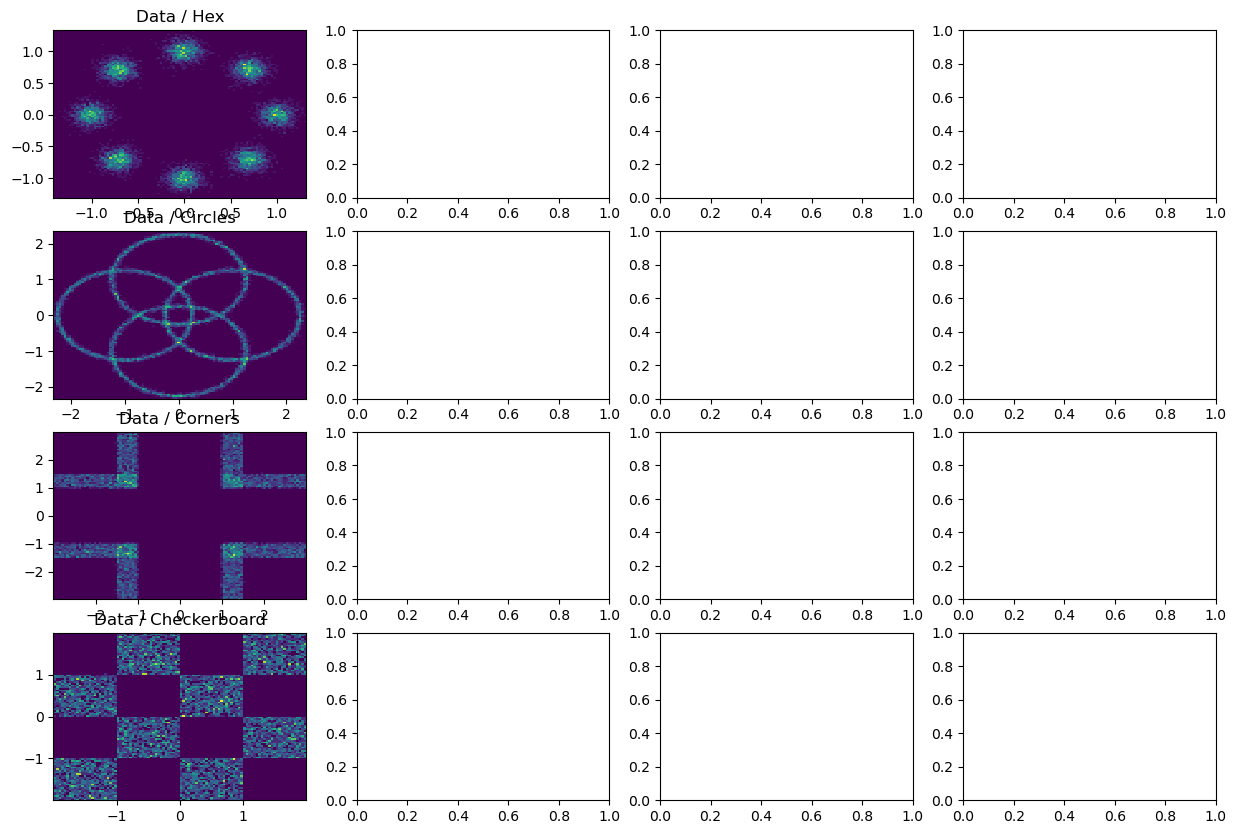

In [5]:
# Define dataset names
default_model_names = ['NF', 'NF + constant abs', 'NF + trained abs']
default_dataset_names = ['Hex', 'Circles', 'Corners', 'Checkerboard']

# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(default_dataset_names), len(default_model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(default_dataset_names, default_dataset_functions)):
    X = dataset_function(SAMPLE_COUNT).cpu().numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=BINS)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps
for i, dataset_name in enumerate(default_dataset_names):
    for j, model_name in enumerate(default_model_names):
        model = models[i, j][0]  # [0] is the model, [1] is parameters/losses for log epochs
        X = model.sample(SAMPLE_COUNT).cpu().numpy()

        axs[i, j + 1].hist2d(X[:, 0], X[:, 1], bins=BINS)
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')

# Adjust layout
plt.tight_layout()
plt.show()

As we can see, the performance for symmetric datasets of NF+abs is much better, whereas the performance for antisymmetric is terrible.

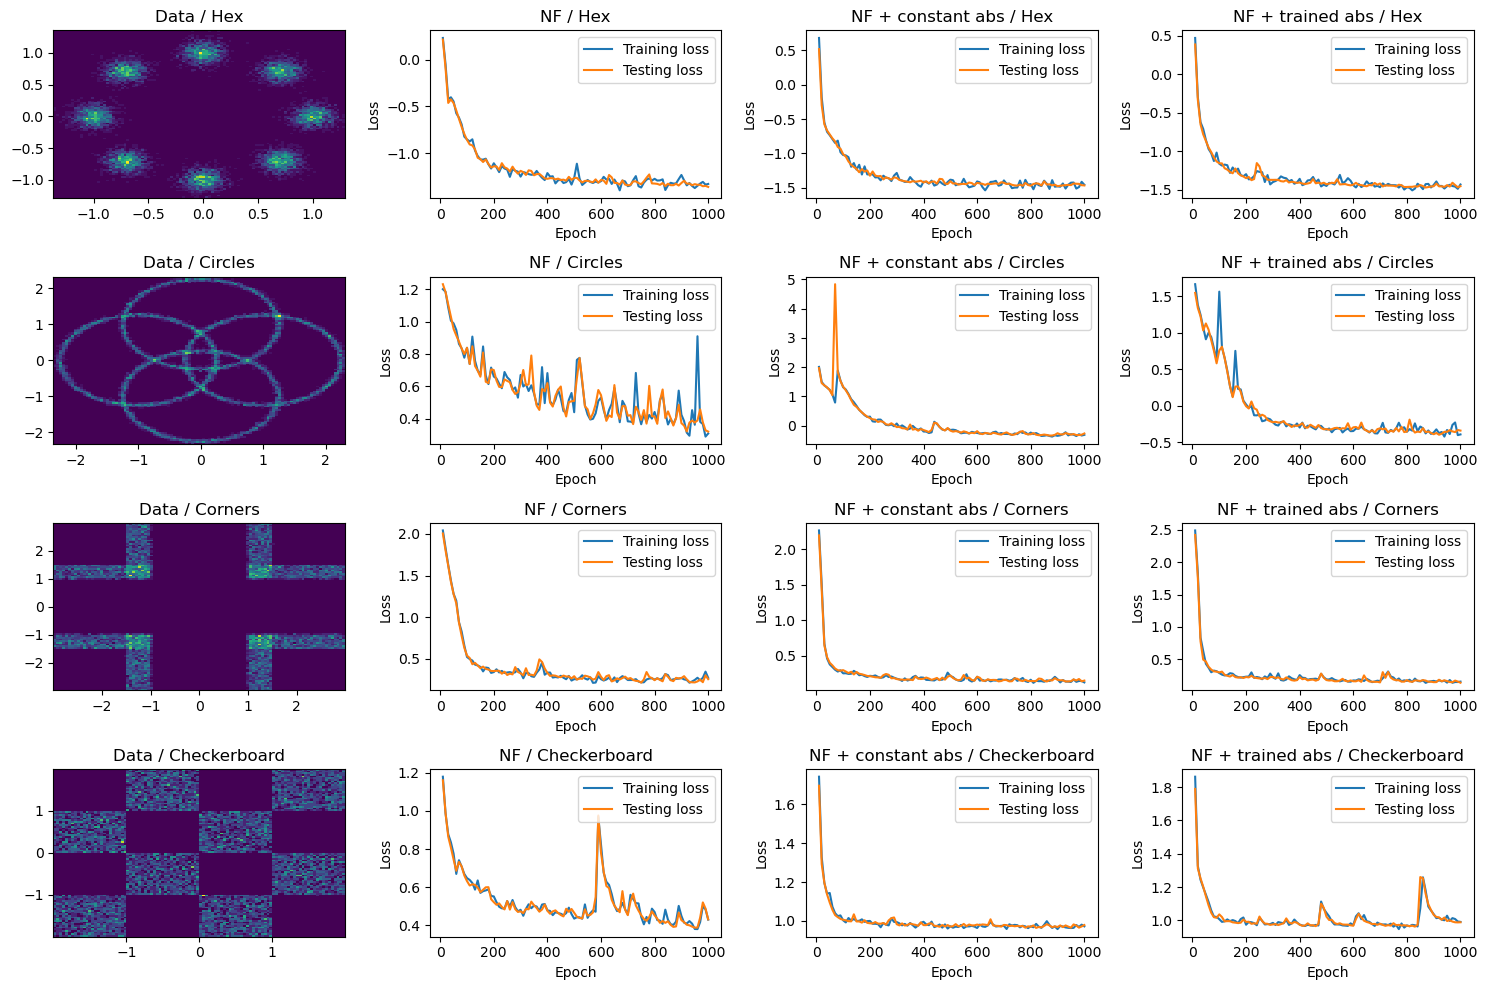

In [8]:
# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(default_dataset_names), len(default_model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(default_dataset_names, default_dataset_functions)):
    X = dataset_function(SAMPLE_COUNT).cpu().numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=BINS)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps for losses
for i, dataset_name in enumerate(default_dataset_names):
    for j, model_name in enumerate(default_model_names):
        training_loss = [l for _, l, _ in models[i, j][1].values()]
        testing_loss = [l for _, _, l in models[i, j][1].values()]
        epoch_values = list(models[i, j][1].keys())

        axs[i, j + 1].plot(epoch_values, training_loss, label='Training loss')
        axs[i, j + 1].plot(epoch_values, testing_loss, label='Testing loss')
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')
        axs[i, j + 1].set_xlabel('Epoch')
        axs[i, j + 1].set_ylabel('Loss')
        axs[i, j + 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

When looking at the ending losses, the plots reflect the observations above - the absolute layer is great for symmetric data but terrible for non-symmetric data.

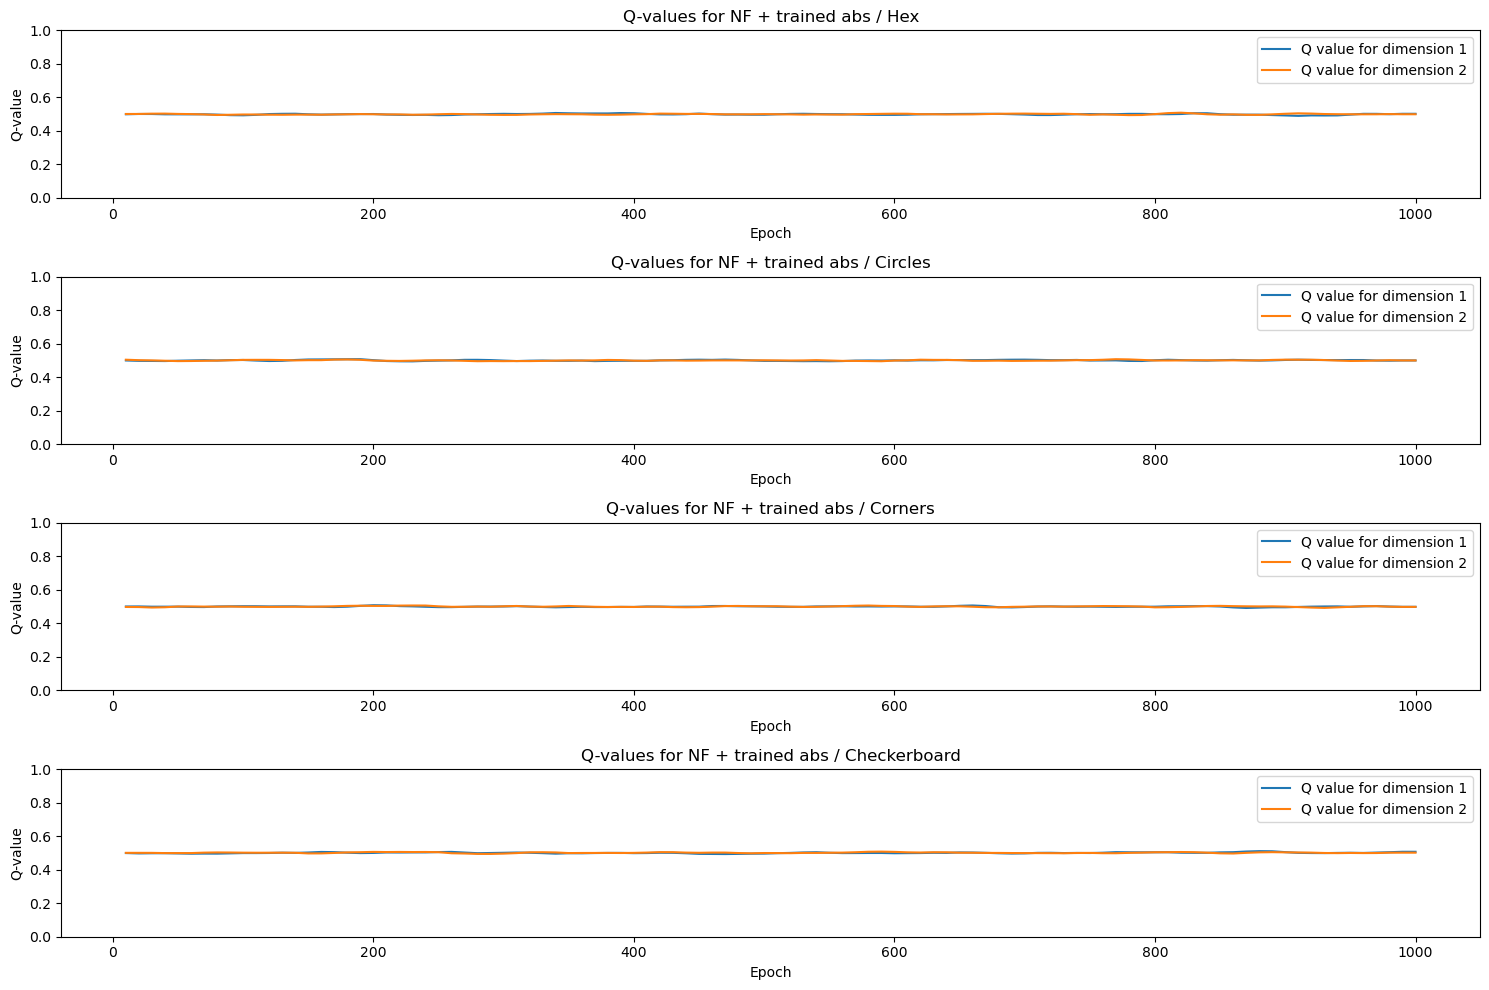

In [9]:
fig, axs = plt.subplots(len(default_dataset_names), 1, figsize=(15, 10))

for i, dataset_name in enumerate(default_dataset_names):
    # We're interested in the last model - that is the one that changes the q
    model, states = models[i, len(default_model_names) - 1]

    q1 = []
    q2 = []
    for epoch, (state_dict, _, _) in states.items():
        model.load_state_dict(state_dict)
        q1.append(model.layers[0].q[0].item())
        q2.append(model.layers[0].q[1].item())

    epoch_values = list(states.keys())

    axs[i].plot(epoch_values, q1, label="Q value for dimension 1")
    axs[i].plot(epoch_values, q2, label="Q value for dimension 2")
    axs[i].set_title(f'Q-values for {default_model_names[-1]} / {dataset_name}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Q-value')
    axs[i].set_ylim([0, 1])
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

The Q-values for the absolute layer that influence the percentage of flipped values stay at 0.5, which makes sense since bot the symmetric/antisymmetric datasets are perfectly symmetric/antisymmetric.

To test whether the Q-values will be correctly learned for skewed data, we can modify the datasets to randomly `abs()` values in a given axis.

# Skewed Datasets

In [9]:
def skew_dataset(dataset_function, n, axis=0, q=0.5):
    """
    Take a dataset and randomly (with probability q) abs() values in the given axis.
    """
    data = dataset_function(n)

    mask = torch.rand(data.size()[0]) < q
    data[mask, axis] = torch.abs(data[mask, axis])
    
    return data


skewed_dataset_functions = [
    (lambda g: (lambda n: skew_dataset(g, n, axis=0, q=0.5)))(f)
    for f in [ngon, circles, corners]
]

In [10]:
# Train the datasets
models = {}

# Iterate over datasets and create heatmaps
for i, dataset_function in enumerate(skewed_dataset_functions):
    for j, model_generator in enumerate(default_model_generators):
        model = model_generator()
        print(
            f"[{i * len(default_model_generators) + j + 1}/{len(skewed_dataset_functions) * len(default_model_generators)}] ",
            end="")
        results = model.train(
            dataset_function, batch_size=BATCH_SIZE, test_size=TEST_SIZE,
            epochs=EPOCHS, lr=0.001, log_count=LOG_COUNT
        )

        models[i, j] = (model, results)


[1/9] Starting training... done in 48.18 seconds
[2/9] Starting training... done in 42.89 seconds
[3/9] Starting training... done in 39.66 seconds
[4/9] Starting training... done in 35.36 seconds
[5/9] Starting training... done in 45.36 seconds
[6/9] Starting training... done in 52.55 seconds
[7/9] Starting training... done in 49.82 seconds
[8/9] Starting training... done in 45.63 seconds
[9/9] Starting training... done in 47.50 seconds


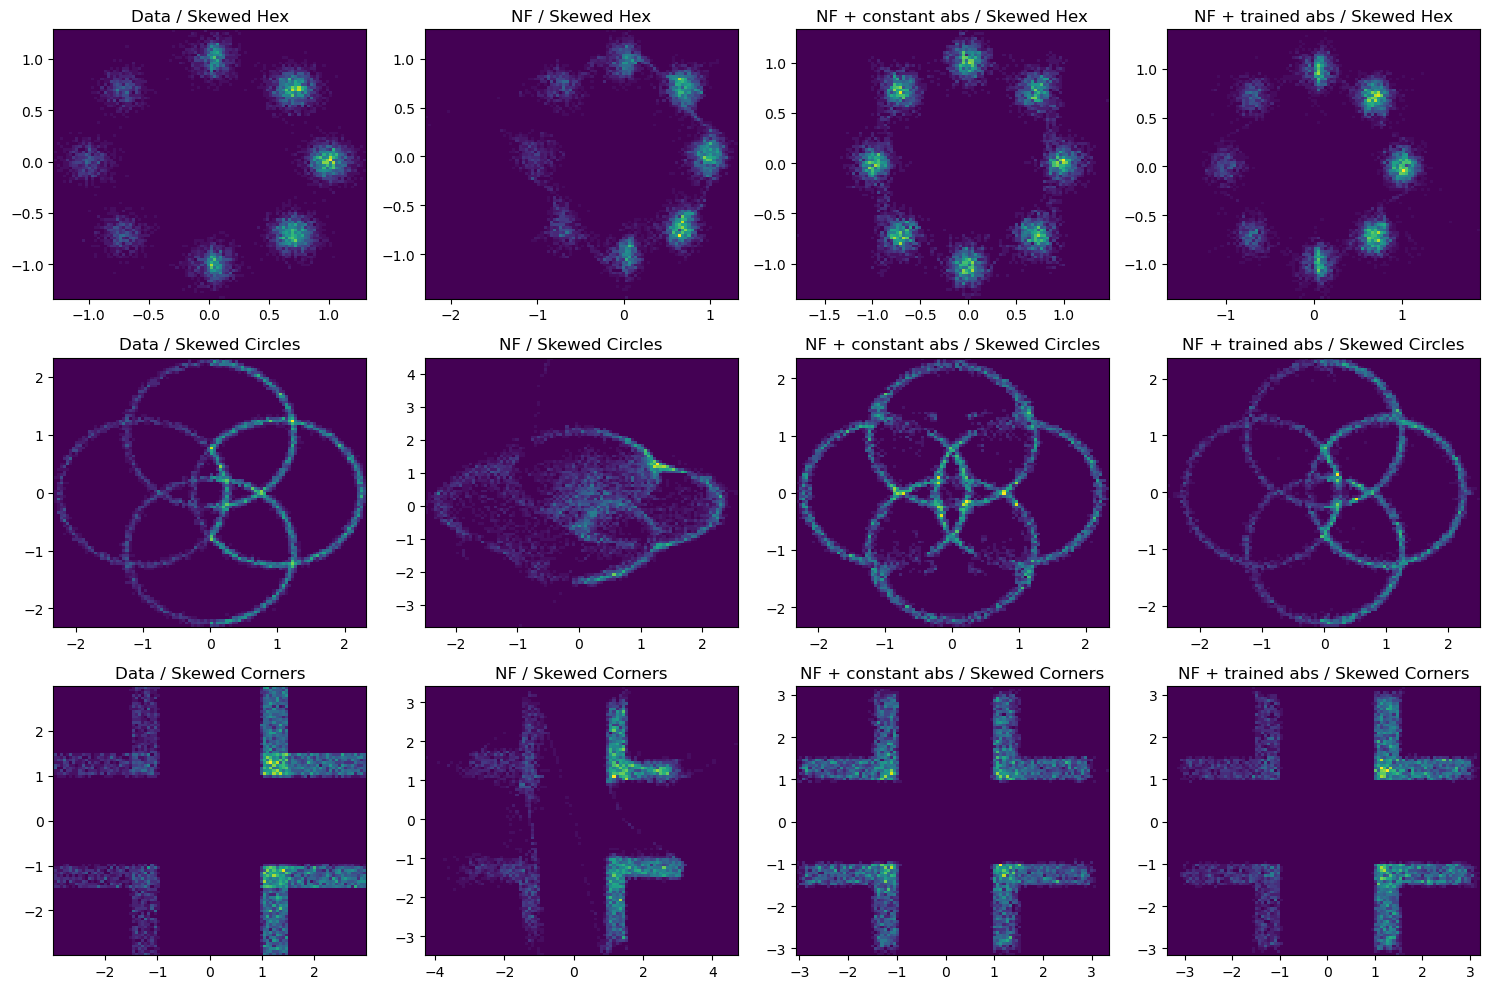

In [11]:
# Define dataset names
default_model_names = ['NF', 'NF + constant abs', 'NF + trained abs']
skewed_dataset_names = ['Skewed Hex', 'Skewed Circles', 'Skewed Corners']

# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(skewed_dataset_names), len(default_model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(skewed_dataset_names, skewed_dataset_functions)):
    X = dataset_function(SAMPLE_COUNT).cpu().numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=BINS)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps
for i, dataset_name in enumerate(skewed_dataset_names):
    for j, model_name in enumerate(default_model_names):
        model = models[i, j][0]  # [0] is the model, [1] is parameters/losses for log epochs
        X = model.sample(SAMPLE_COUNT).cpu().numpy()

        axs[i, j + 1].hist2d(X[:, 0], X[:, 1], bins=BINS)
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')

# Adjust layout
plt.tight_layout()
plt.show()

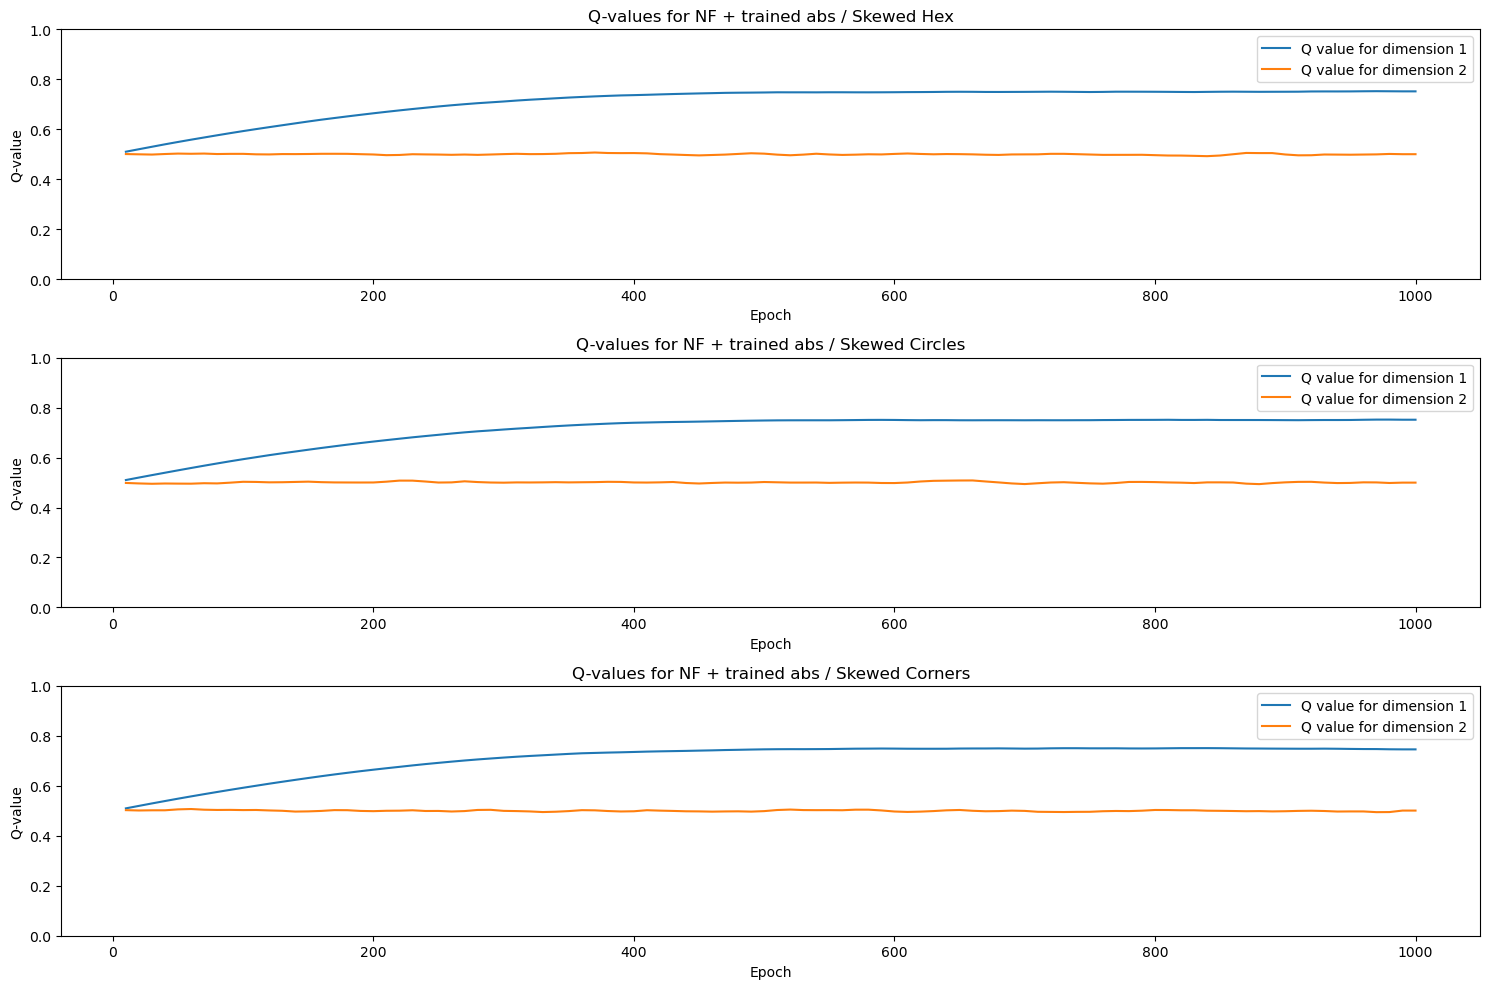

In [12]:
fig, axs = plt.subplots(len(skewed_dataset_names), 1, figsize=(15, 10))

for i, dataset_name in enumerate(skewed_dataset_names):
    # We're interested in the last model - that is the one that changes the q
    model, states = models[i, len(default_model_names) - 1]

    q1 = []
    q2 = []
    for epoch, (state_dict, _, _) in states.items():
        model.load_state_dict(state_dict)
        q1.append(model.layers[0].q[0].item())
        q2.append(model.layers[0].q[1].item())

    epoch_values = list(states.keys())

    axs[i].plot(epoch_values, q1, label="Q value for dimension 1")
    axs[i].plot(epoch_values, q2, label="Q value for dimension 2")
    axs[i].set_title(f'Q-values for {default_model_names[-1]} / {dataset_name}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Q-value')
    axs[i].set_ylim([0, 1])
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

With the skew being 0.5, we move half of the data to the positive side, meaning that the split is 1/4 negative and 3/4 positive. This justifies the Q-value of 0.75.

# Calibration

In [ ]:
model = models[len(default_dataset_names) - 1, len(default_model_names) - 1][0]

In [ ]:
X_test = model.sample(100)
cs = calc_cs(model, X_test, 50)

In [ ]:
plot_histogram(cs[0], 20, "Calibration diagram for x-axis")
plot_histogram(cs[1], 20, "Calibration diagram for y-axis")

In [ ]:
plot_cdf(cs[0])

# Offset Datasets

Offsetting the datasets breaks the current network structure because the absolute layer is at the very beginning.

In [20]:
offset = torch.tensor([1, 1])

offset_dataset_functions = [
    (lambda g: (lambda n: (g(n) + offset)))(f)
    for f in default_dataset_functions
]

In [23]:
# Train the datasets
models = {}

# Iterate over datasets and create heatmaps
for i, dataset_function in enumerate(offset_dataset_functions):
    for j, model_generator in enumerate(default_model_generators):
        model = model_generator()
        print(
            f"[{i * len(default_model_generators) + j + 1}/{len(offset_dataset_functions) * len(default_model_generators)}] ",
            end="")
        results = model.train(
            dataset_function, batch_size=BATCH_SIZE, test_size=TEST_SIZE,
            epochs=EPOCHS, lr=0.001, log_count=LOG_COUNT
        )

        models[i, j] = (model, results)

[1/12] Starting training... done in 48.25 seconds
[2/12] Starting training... done in 49.91 seconds
[3/12] Starting training... done in 50.13 seconds
[4/12] Starting training... done in 46.17 seconds
[5/12] Starting training... done in 43.90 seconds
[6/12] Starting training... done in 44.63 seconds
[7/12] Starting training... done in 43.88 seconds
[8/12] Starting training... done in 49.15 seconds
[9/12] Starting training... done in 49.03 seconds
[10/12] Starting training... done in 57.04 seconds
[11/12] Starting training... done in 55.34 seconds
[12/12] Starting training... done in 55.08 seconds


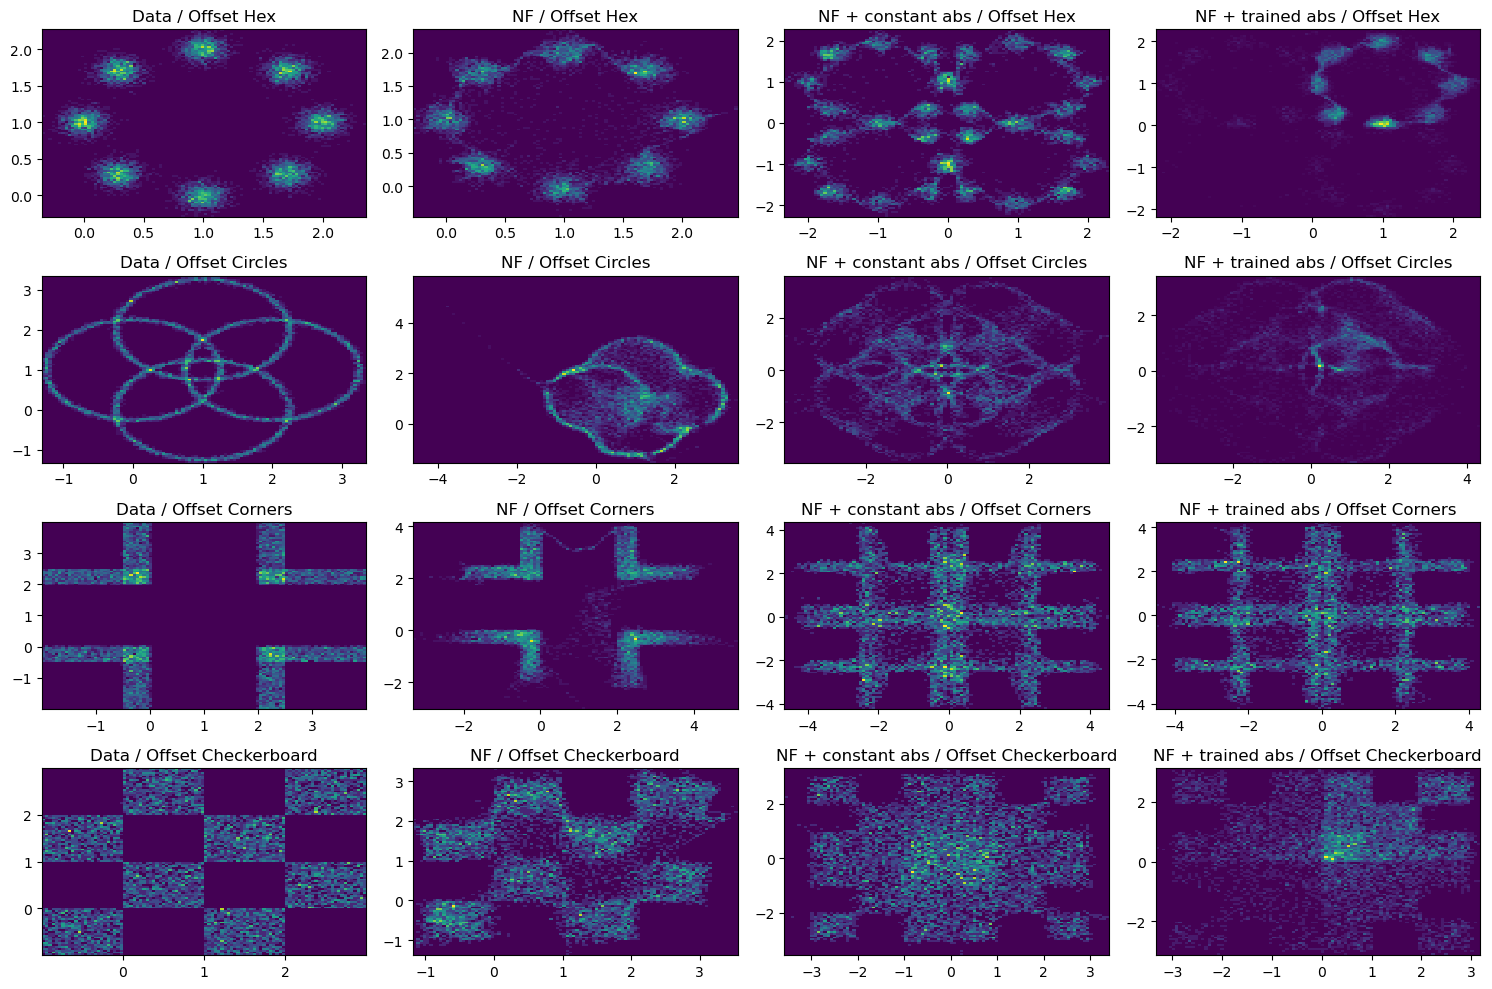

In [25]:
# Define dataset names
default_model_names = ['NF', 'NF + constant abs', 'NF + trained abs']
offset_dataset_names = ['Offset Hex', 'Offset Circles', 'Offset Corners', 'Offset Checkerboard']

# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(offset_dataset_names), len(default_model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(offset_dataset_names, offset_dataset_functions)):
    X = dataset_function(SAMPLE_COUNT).cpu().numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=BINS)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps
for i, dataset_name in enumerate(offset_dataset_names):
    for j, model_name in enumerate(default_model_names):
        model = models[i, j][0]  # [0] is the model, [1] is parameters/losses for log epochs
        X = model.sample(SAMPLE_COUNT).cpu().numpy()

        axs[i, j + 1].hist2d(X[:, 0], X[:, 1], bins=BINS)
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')

# Adjust layout
plt.tight_layout()
plt.show()

To fix this, we can change the structure by moving it in the middle and let the bijective layers handle the transformation.

In [26]:
middle_model_generators = [
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
    ),
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ] + [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2])),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ],
    ),
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ] + [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2]), learn_q=True),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ],
    )
]

In [38]:
# Train the datasets
models = {}

# Iterate over datasets and create heatmaps
for i, dataset_function in enumerate(offset_dataset_functions):
    for j, model_generator in enumerate(middle_model_generators):
        model = model_generator()
        print(
            f"[{i * len(middle_model_generators) + j + 1}/{len(offset_dataset_functions) * len(middle_model_generators)}] ",
            end="")
        results = model.train(
            dataset_function, batch_size=BATCH_SIZE, test_size=TEST_SIZE,
            epochs=EPOCHS, lr=0.001, log_count=LOG_COUNT
        )

        models[i, j] = (model, results)

[1/12] Starting training... done in 45.73 seconds
[2/12] Starting training... done in 49.64 seconds
[3/12] Starting training... done in 51.02 seconds
[4/12] Starting training... done in 48.38 seconds
[5/12] Starting training... done in 49.06 seconds
[6/12] Starting training... done in 46.25 seconds
[7/12] Starting training... done in 46.25 seconds
[8/12] Starting training... done in 48.90 seconds
[9/12] Starting training... done in 47.70 seconds
[10/12] Starting training... done in 53.63 seconds
[11/12] Starting training... done in 56.63 seconds
[12/12] Starting training... done in 55.60 seconds


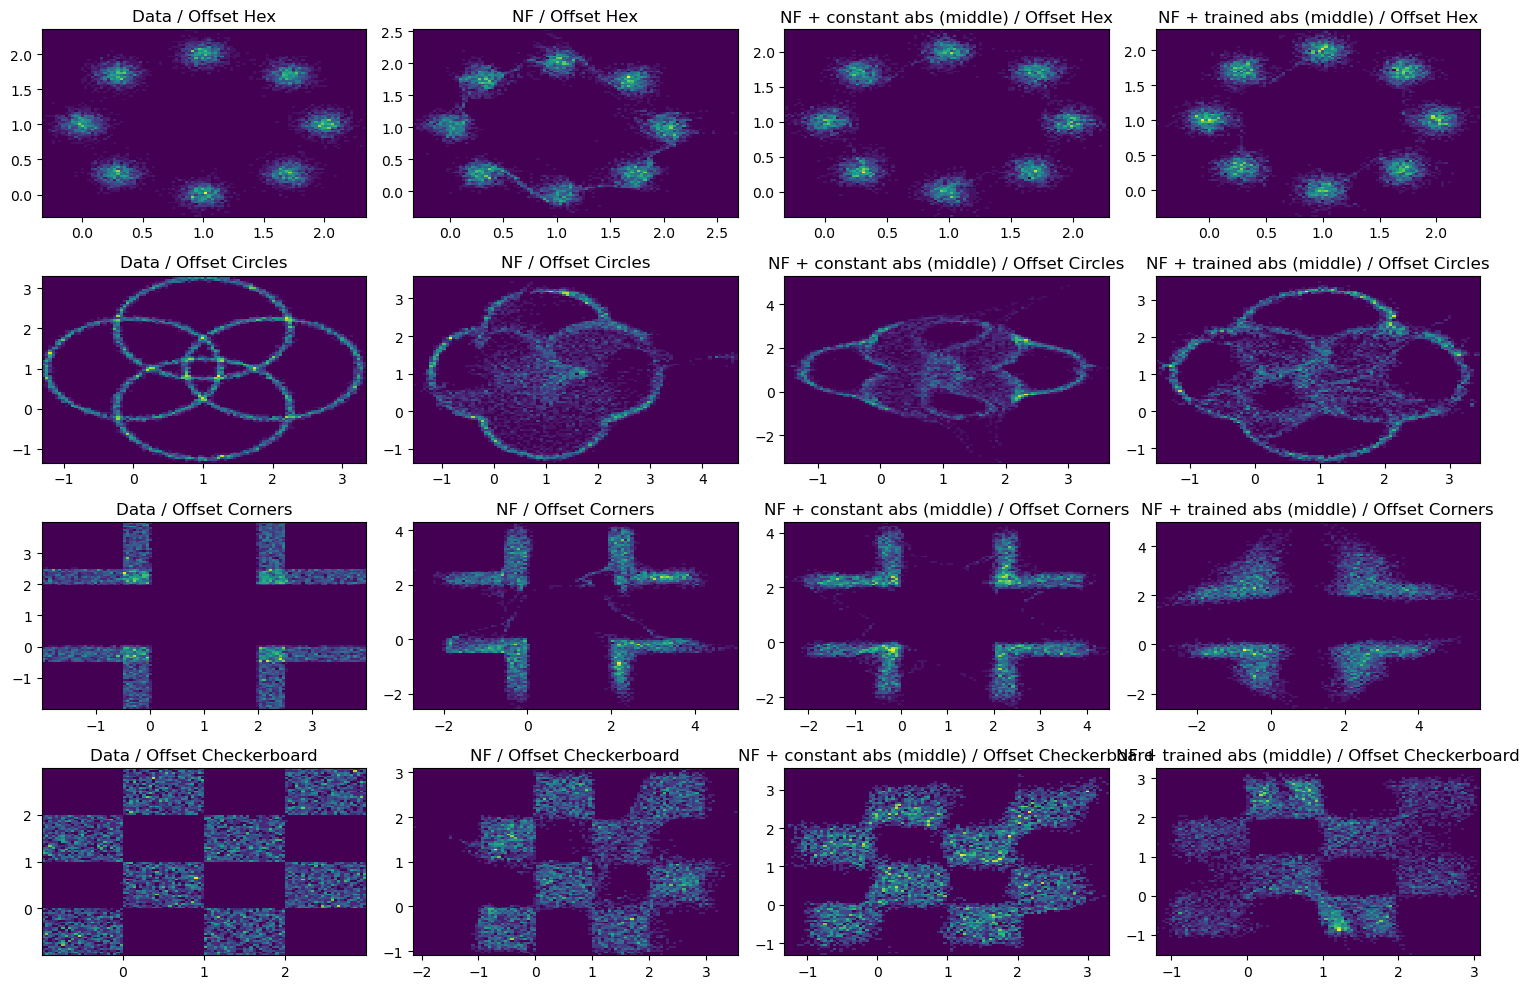

In [43]:
# Define dataset names
middle_model_names = ['NF', 'NF + constant abs (middle)', 'NF + trained abs (middle)']
offset_dataset_names = ['Offset Hex', 'Offset Circles', 'Offset Corners', 'Offset Checkerboard']

# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(offset_dataset_names), len(default_model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(offset_dataset_names, offset_dataset_functions)):
    X = dataset_function(SAMPLE_COUNT).cpu().numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=BINS)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps
for i, dataset_name in enumerate(offset_dataset_names):
    for j, model_name in enumerate(default_model_names):
        model = models[i, j][0]  # [0] is the model, [1] is parameters/losses for log epochs
        X = model.sample(SAMPLE_COUNT).cpu().numpy()

        axs[i, j + 1].hist2d(X[:, 0], X[:, 1], bins=BINS)
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')

# Adjust layout
plt.tight_layout()
plt.show()

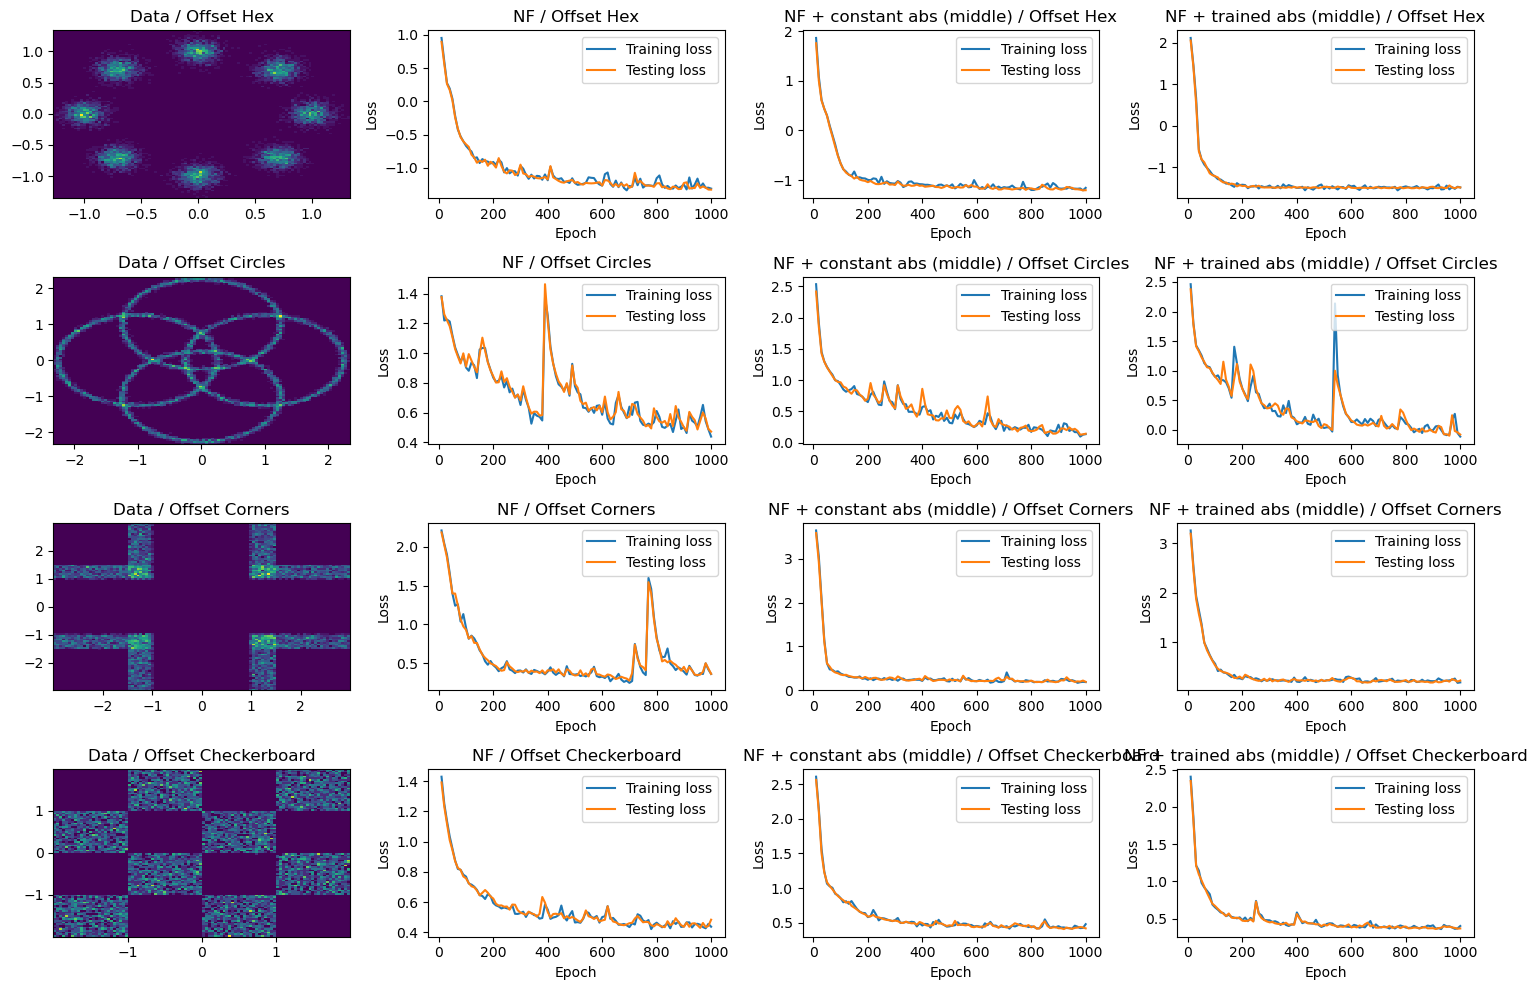

In [32]:
# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(offset_dataset_names), len(middle_model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(offset_dataset_names, default_dataset_functions)):
    X = dataset_function(SAMPLE_COUNT).cpu().numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=BINS)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps for losses
for i, dataset_name in enumerate(offset_dataset_names):
    for j, model_name in enumerate(middle_model_names):
        training_loss = [l for _, l, _ in models[i, j][1].values()]
        testing_loss = [l for _, _, l in models[i, j][1].values()]
        epoch_values = list(models[i, j][1].keys())

        axs[i, j + 1].plot(epoch_values, training_loss, label='Training loss')
        axs[i, j + 1].plot(epoch_values, testing_loss, label='Testing loss')
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')
        axs[i, j + 1].set_xlabel('Epoch')
        axs[i, j + 1].set_ylabel('Loss')
        axs[i, j + 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

Here it's interesting to visualize the symmetry axes.

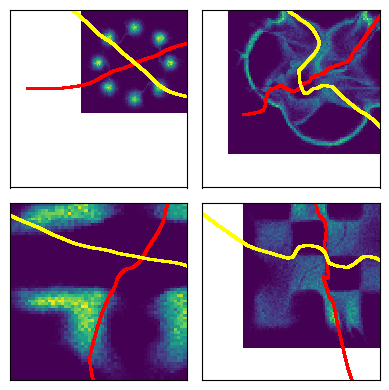

In [42]:
last_models = [models[i, len(middle_model_names)-1][0] for i in range(len(offset_dataset_names))]

n_models = len(last_models)

n_cols = 2  # set manually
n_rows = n_models // n_cols

axis_len = 8  # sample length for axis visualization
axis_n_samples = 10_000  # number of samples per axis
distr_n_samples = 100_000  # number of samples for distribution

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i in range(n_models):
    model = last_models[i]
    k = i // n_cols

    with torch.no_grad():
        samples = model.sample(distr_n_samples).cpu().numpy()

        _axis = torch.linspace(-axis_len, axis_len, axis_n_samples)
        _zeros = torch.zeros(axis_n_samples)

        x_axis = torch.stack((_axis, _zeros), dim=1)
        y_axis = torch.stack((_zeros, _axis), dim=1)

        for layer in reversed(model.layers[:9]):
            x_axis = layer.backward(x_axis)
            y_axis = layer.backward(y_axis)

    x_axis = x_axis.cpu()
    y_axis = y_axis.cpu()

    # choose right subfigure
    if n_cols == 1 and n_rows == 1:
        _ax = ax
    elif n_cols == 1 or n_rows == 1:
        _ax = ax[max(k, i % n_cols)]
    else:
        _ax = ax[k, i % n_cols]

    _ax.hist2d(samples[:, 0], samples[:, 1], bins=100)
    _ax.scatter(x_axis[:, 0], x_axis[:, 1], s=1, c="red")
    _ax.scatter(y_axis[:, 0], y_axis[:, 1], s=1, c="yellow")

    _ax.set_xlim(-2.5, 2.5)
    _ax.set_ylim(-2.5, 2.5)
    _ax.set_aspect("equal")

    _ax.set_xticks([])
    _ax.set_yticks([])

plt.tight_layout()
plt.show()

# TODO: ended here

# Spatial MNIST

In [ ]:
default_model_generators = [
    lambda: SurVAE(
        [
            [BijectiveLayer(100, [64] * 5), OrthonormalLayer(100)]
            for _ in range(20)
        ],
    ),
    lambda: SurVAE(
        [
            [BijectiveLayer(100, [64] * 5), OrthonormalLayer(100)]
            for _ in range(10)
        ] + [
            SortingLayer(),
        ] + [
            [BijectiveLayer(100, [64] * 5), OrthonormalLayer(100)]
            for _ in range(9)
        ],
    ),
]

In [ ]:
# Train the datasets
models = {}
BATCH_SIZE = 1_000
TEST_SIZE = 10_000
EPOCHS = 5000
LOG_COUNT = EPOCHS // 10

# Iterate over datasets and create heatm aps
for i, model_generator in enumerate(default_model_generators):
    model = model_generator()
    print(f"[{i + 1}/{len(default_model_generators)}] ", end="")

    results = model.train(
        get_spatial_mnist, batch_size=BATCH_SIZE, test_size=TEST_SIZE,
        epochs=EPOCHS, lr=0.001, log_count=LOG_COUNT
    )

    models[i] = (model, results)

In [ ]:
default_model_names = ['NF', 'NF + sorting']

In [ ]:
rows = 4 * (1 + len(default_model_generators))
columns = 10
smnist = get_spatial_mnist(rows * columns)

# Plot the first k*l images with sampled points in a 2D grid
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 10))

for i in range(rows):
    for j in range(columns):
        if i // 4 == 0:
            sample = smnist[i * columns + j]
        elif i // 4 == 1:
            sample = models[0][0].sample(1)[0]
        elif i // 4 == 2:
            sample = models[1][0].sample(1)[0]
        else:
            raise Exception("Should not have happened!")

        ax = axes[i, j]
        points = sample.cpu().numpy().reshape(50, 2)

        ax.scatter(points[:, 0], -points[:, 1], s=15, label='Sampled Points')

        ax.axis('off')
        ax.set_aspect('equal')

plt.show()

In [ ]:
# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(1, len(default_model_names), figsize=(15, 10))

# Iterate over datasets and create heatmaps for losses
for i, model_name in enumerate(default_model_names):
    training_loss = [l for _, l, _ in models[i][1].values()]
    testing_loss = [l for _, _, l in models[i][1].values()]
    EPOCHS = list(models[i][1].keys())

    axs[i].plot(EPOCHS, training_loss, label='Training loss')
    axs[i].plot(EPOCHS, testing_loss, label='Testing loss')
    axs[i].set_title(f'{model_name}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].legend()
    axs[i].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()

# Visualizing symmetry lines

## Checkerboard

In [ ]:
model_generator = lambda: SurVAE(
    [
        [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2), ]
        for _ in range(6)
    ] + [
        [AbsoluteUnit, [1 / 2], {'learn_q': True}],
    ] + [
        [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2), ]
        for _ in range(6)
    ],
)

In [12]:
models = [model_generator() for _ in range(4)]

In [26]:
for model in models:
    model.train(checkerboard, epochs=100)

Starting training... done in 10.33 seconds
Starting training... done in 10.14 seconds
Starting training... done in 10.22 seconds
Starting training... done in 10.22 seconds


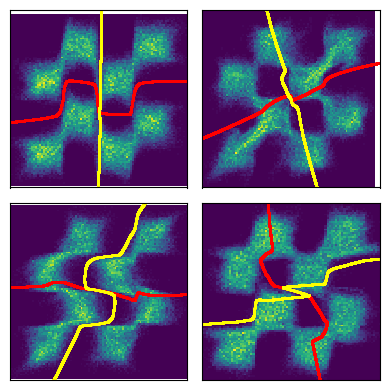

In [27]:
n_models = len(models)

n_cols = 2  # set manually
n_rows = n_models // n_cols

axis_len = 8  # sample length for axis visualization
axis_n_samples = 10_000  # number of samples per axis
distr_n_samples = 100_000  # number of samples for distribution

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i in range(n_models):
    model = models[i]
    k = i // n_cols

    with torch.no_grad():
        samples = model.sample(distr_n_samples).cpu().numpy()

        _axis = torch.linspace(-axis_len, axis_len, axis_n_samples)
        _zeros = torch.zeros(axis_n_samples)

        x_axis = torch.stack((_axis, _zeros), dim=1)
        y_axis = torch.stack((_zeros, _axis), dim=1)

        for layer in reversed(model.layers[:9]):
            x_axis = layer.backward(x_axis)
            y_axis = layer.backward(y_axis)

    x_axis = x_axis.cpu()
    y_axis = y_axis.cpu()

    # choose right subfigure
    if n_cols == 1 and n_rows == 1:
        _ax = ax
    elif n_cols == 1 or n_rows == 1:
        _ax = ax[max(k, i % n_cols)]
    else:
        _ax = ax[k, i % n_cols]

    _ax.hist2d(samples[:, 0], samples[:, 1], bins=100)
    _ax.scatter(x_axis[:, 0], x_axis[:, 1], s=1, c="red")
    _ax.scatter(y_axis[:, 0], y_axis[:, 1], s=1, c="yellow")

    _ax.set_xlim(-2.5, 2.5)
    _ax.set_ylim(-2.5, 2.5)
    _ax.set_aspect("equal")

    _ax.set_xticks([])
    _ax.set_yticks([])

plt.tight_layout()
plt.show()

## Other patterns TODO